In [50]:
import torch
from torch import nn
from torch.utils.data import DataLoader

@torch.inference_mode()
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
	model.eval()

	with torch.no_grad():
		iterations_list = []
		for it in range(iterations):
			iter_list = []
			for x, y in loader:
				x, y = x.to(device), y.to(device)

				output = model(x)

				iter_list.append(output)

			iterations_list.append(torch.concat(iter_list).unsqueeze(0))

	res = torch.concat(iterations_list)

	return torch.argmax(res.mean(dim=0), dim=1)

r = predict_tta(model, valid_loader, 'cuda:0')

In [32]:
list(map(lambda t: t.))

torch.Size([20000, 10])

In [40]:
res = torch.concat(list(map(lambda t: t.unsqueeze(0), i1)))

In [42]:
res.shape

torch.Size([2, 10000, 10])

In [47]:
torch.argmax(res.mean(dim=0), dim=1).shape

torch.Size([10000])

In [28]:
import torch

def get_normalize(features: torch.Tensor):
	mean = features.mean(dim=[0,2,3])
	std = features.std(dim=[0,2,3])

	return (mean, std) 

a = torch.rand((5,3,28,28))
get_normalize(a)

(tensor([0.5089, 0.5039, 0.5011]), tensor([0.2895, 0.2884, 0.2933]))

In [ ]:
from torchvision.transforms import v2 as T

def get_augmentations(train: bool = True) -> T.Compose:

	train_transforms = T.Compose([
        T.Resize(size=224),
		T.RandomRotation(degrees=(0, 180)),
        T.ToTensor(),
        T.Normalize()
    ])

	test_transforms = T.Compose(
		[
			T.Resize(size=224),
			T.ToTensor(),
			T.Normalize()
		]
	)

In [1]:
%load_ext autoreload
%autoreload 2
from task6 import get_augmentations

In [42]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10  # https://www.cs.toronto.edu/~kriz/cifar.html
from task6 import get_augmentations

class FirstModel(nn.Module):
    def __init__(self):
        super().__init__()
	
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # 224 x 224 x 16
            nn.ReLU(),

            nn.MaxPool2d(2),  # 112 x 112 x 16

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 112 x 112 x 32
            nn.ReLU(),

            nn.MaxPool2d(2),  # 56 x 56 x 32

            nn.Flatten(),

            nn.Linear(56 * 56 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

train_dataset = CIFAR10('data', train=True, transform=get_augmentations(train=True), download=True)
valid_dataset = CIFAR10('data', train=False, transform=get_augmentations(train=False), download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    preds = []

    with torch.no_grad():
        for x,y in loader:
            y_pred = torch.argmax(model(x), dim=1)
            preds.append(y_pred)

    return torch.concat(preds)

Files already downloaded and verified


Files already downloaded and verified


In [43]:
predict(FirstModel(),valid_loader, 'cuda:0')

tensor([6, 6, 6,  ..., 6, 6, 6])

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10  # https://www.cs.toronto.edu/~kriz/cifar.html
from task6 import get_augmentations
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
from IPython.display import clear_output


# if device.cuda.is_available():
# 	device = 'cuda:0'
# 	pin_memeory = True

device, pin_memory = ('cuda:0', True) if torch.cuda.is_available() else ('cpu', False)

train_dataset = CIFAR10('data', train=True, transform=get_augmentations(train=True), download=True)
valid_dataset = CIFAR10('data', train=False, transform=get_augmentations(train=False), download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=pin_memory)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=pin_memory)

loss_fn = nn.CrossEntropyLoss()

def train(model: nn.Module, optimizer, loss_fn) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

@torch.inference_mode()
def evaluate(model: nn.Module) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(valid_loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(valid_loader)
    accuracy = correct / total

    return total_loss, accuracy

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(10, 4))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

def whole_train_valid_cycle(model, num_epochs, title, optimizer, loss_fn):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, optimizer, loss_fn)
        valid_loss, valid_accuracy = evaluate(model)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )


Files already downloaded and verified
Files already downloaded and verified


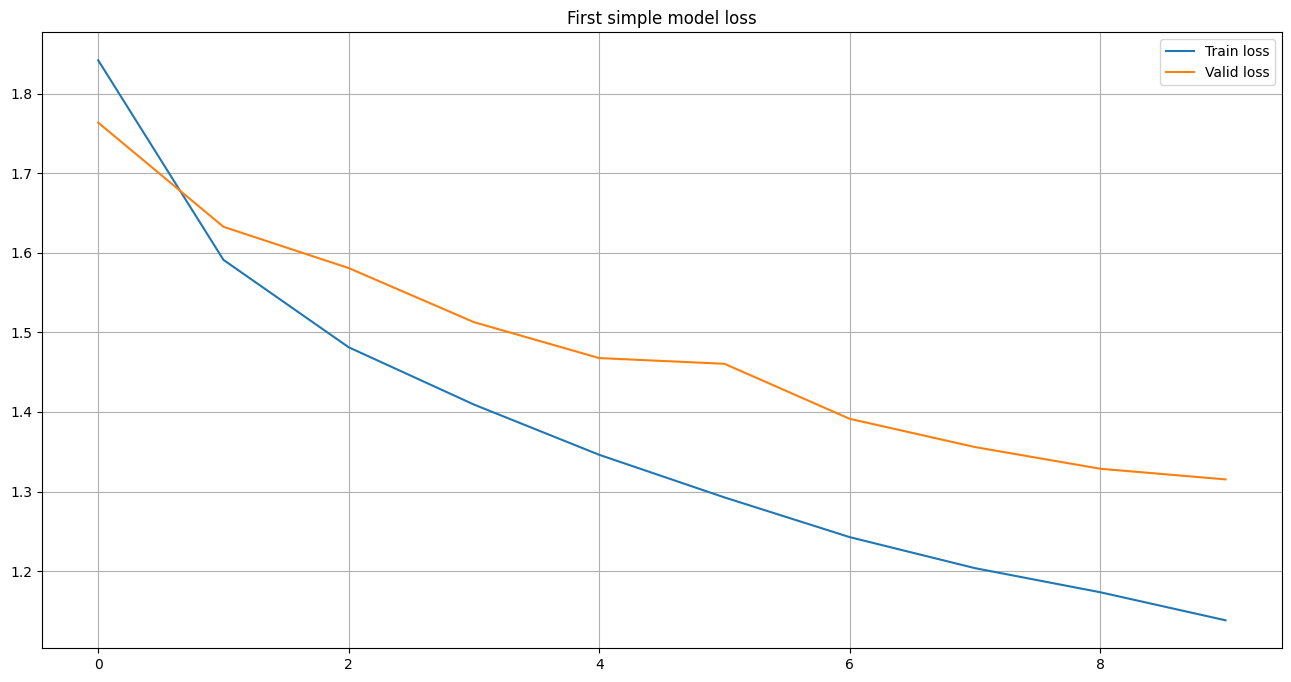

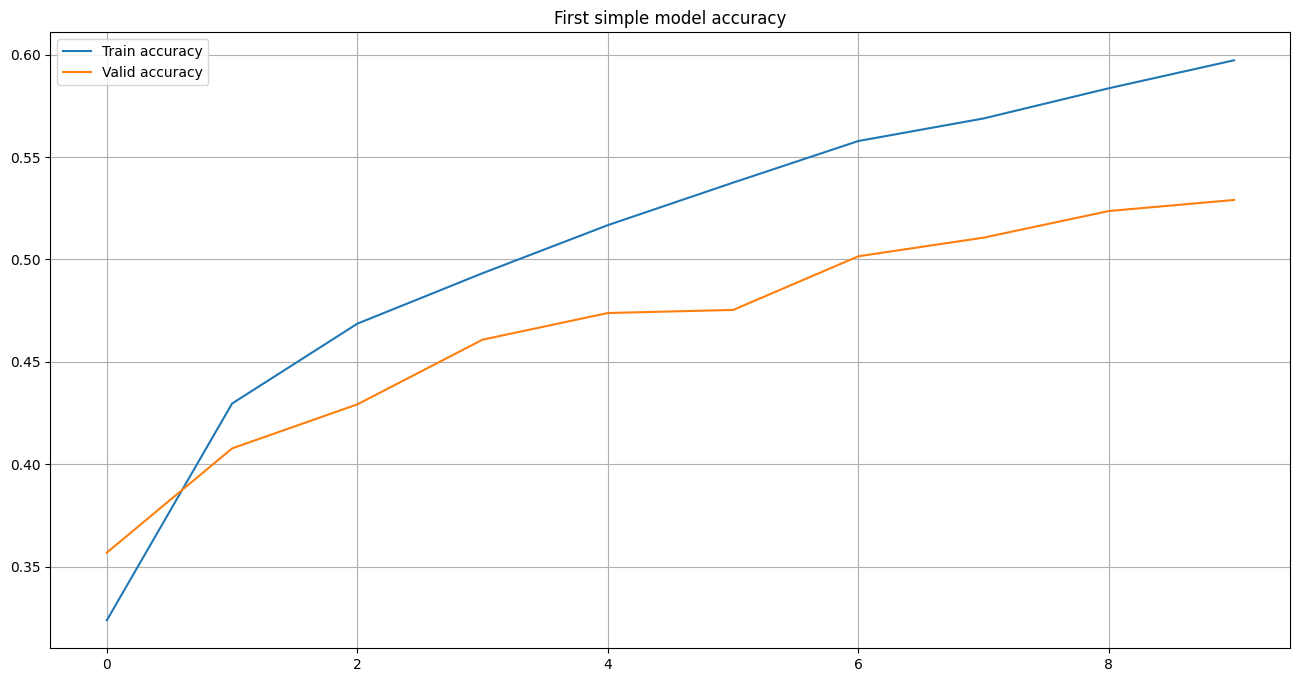

In [15]:
class FirstModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # 32 x 32 x 16
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 16

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 16 x 16 x 32
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32

            nn.Flatten(),

            nn.Linear(8 * 8 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

model = FirstModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 10, 'First simple model', optimizer, loss_fn)